In [1]:
import os
import numpy as np
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
data_dir=Path("./captcha_images_v2/")
img_dir=os.getcwd()
img_dir=img_dir+"\\captcha_images_v2\\"

In [3]:
os.listdir(data_dir)[0:5]

['226md.png', '22d5n.png', '2356g.png', '23mdg.png', '23n88.png']

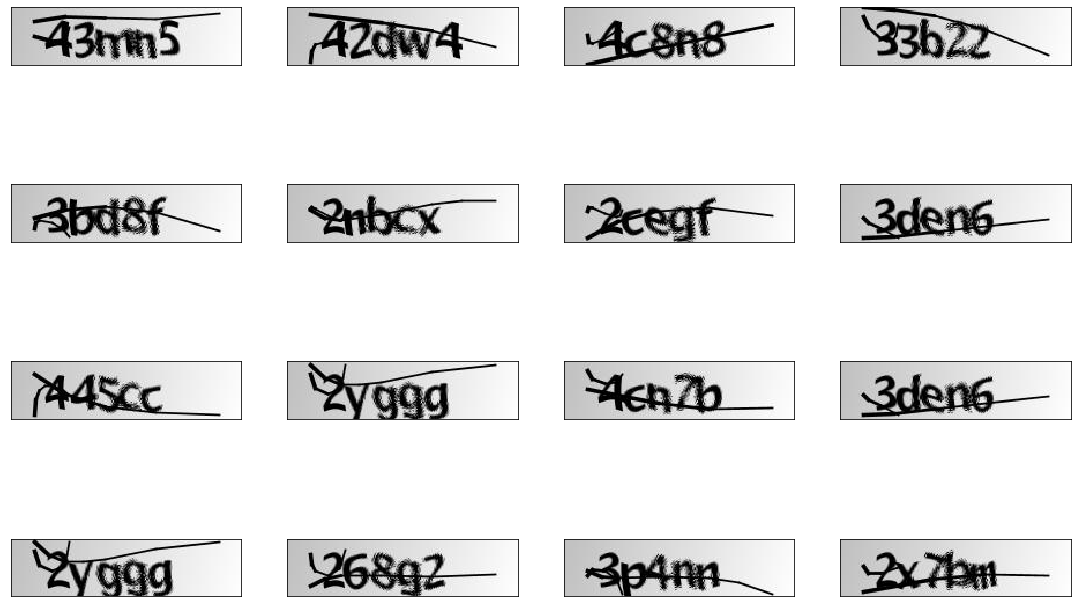

In [4]:
plt.figure(figsize=(19,12.5))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.grid(False)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    rn=np.random.randint(0,130)
    imgpath=os.listdir(data_dir)[rn]
    imgpath=img_dir+imgpath
    plt.imshow(imread(imgpath))
plt.show()

In [5]:
images=sorted(list(map(str,list(data_dir.glob("*.png")))))
labels=[img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters=set(char for label in labels for char in label)
print(characters)

{'7', 'm', 'd', '5', '8', 'f', 'c', '4', '2', 'e', 'y', '3', 'n', '6', 'w', 'x', 'g', 'b', 'p'}


In [6]:
img=images[0]
img.split(os.path.sep)[-1].split(".png")[0]

'226md'

In [7]:
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'7', 'm', 'd', '5', '8', 'f', 'c', '4', '2', 'e', 'y', '3', 'n', '6', 'w', 'x', 'g', 'b', 'p'}


In [8]:
batch_size=16
img_width=200
img_height=50

In [9]:
downsample_factor=4

In [10]:
max_length=max([len(label) for label in labels])
max_length

5

In [11]:
char_to_num=layers.experimental.preprocessing.StringLookup(
   vocabulary=list(characters),num_oov_indices=0,mask_token=None)

In [12]:
char_to_num.get_vocabulary()

['7',
 'm',
 'd',
 '5',
 '8',
 'f',
 'c',
 '4',
 '2',
 'e',
 'y',
 '3',
 'n',
 '6',
 'w',
 'x',
 'g',
 'b',
 'p']

In [13]:
num_to_char=layers.experimental.preprocessing.StringLookup(
   vocabulary=char_to_num.get_vocabulary(),mask_token=None,invert=True)

In [14]:
def split_data(images,labels,train_size=0.9,shuffle=True):
    size=len(images)
    indices=np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples=int(size*train_size)
    x_train,y_train=images[indices[:train_samples]],labels[indices[:train_samples]]
    x_test,y_test=images[indices[train_samples:]],labels[indices[train_samples:]]
    return x_train,x_test,y_train,y_test

In [15]:
x_train, x_test, y_train, y_test = split_data(np.array(images), np.array(labels))

In [16]:
def encode_single_sample(img_path,label):
    img=tf.io.read_file(img_path)
    img=tf.io.decode_png(img,channels=1)
    img=tf.image.convert_image_dtype(img,tf.float32)
    img=tf.image.resize(img,[img_height,img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

In [17]:
encode_single_sample(images[0],labels[0])

{'image': <tf.Tensor: shape=(200, 50, 1), dtype=float32, numpy=
 array([[[0.75294125],
         [0.75294125],
         [0.75294125],
         ...,
         [0.76470596],
         [0.76470596],
         [0.76470596]],
 
        [[0.75294125],
         [0.75294125],
         [0.75294125],
         ...,
         [0.76470596],
         [0.76470596],
         [0.76470596]],
 
        [[0.75294125],
         [0.75294125],
         [0.75294125],
         ...,
         [0.76470596],
         [0.76470596],
         [0.76470596]],
 
        ...,
 
        [[0.9843138 ],
         [0.9843138 ],
         [0.9843138 ],
         ...,
         [0.9960785 ],
         [0.9960785 ],
         [0.9960785 ]],
 
        [[0.9843138 ],
         [0.9843138 ],
         [0.9843138 ],
         ...,
         [0.9960785 ],
         [0.9960785 ],
         [0.9960785 ]],
 
        [[0.9843138 ],
         [0.9843138 ],
         [0.9843138 ],
         ...,
         [0.9960785 ],
         [0.9960785 ],
         [0.99607

In [18]:
train_dataset=tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset=(train_dataset.map(encode_single_sample,num_parallel_calls=tf.data.experimental.AUTOTUNE)
                            .batch(batch_size)
                            .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))

In [19]:
validation_dataset=tf.data.Dataset.from_tensor_slices((x_test,y_test))
validation_dataset=(validation_dataset.map(encode_single_sample,num_parallel_calls=tf.data.experimental.AUTOTUNE)
                            .batch(batch_size)
                            .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))

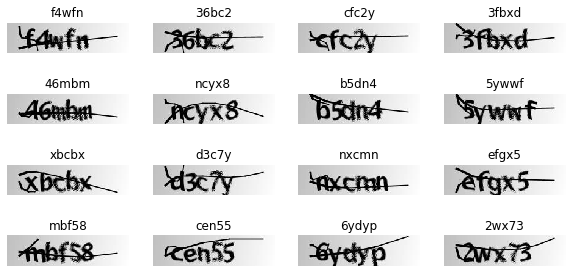

In [20]:
_,ax=plt.subplots(4,4,figsize=(10,5))
for batch in train_dataset.take(1):
    images=batch["image"]
    labels=batch["label"]
    for i in range(16):
        img=(images[i]*255).numpy().astype('uint8')
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [27]:
class CTCLayer(layers.Layer):
    
    def __init__(self,name=None):
        super().__init__(name=name)
        self.loss_fn=keras.backend.ctc_batch_cost
    
    def call(self,y_true,y_pred):
        batch_len=tf.cast(tf.shape(y_true)[0],dtype="int64")
        input_length=tf.cast(tf.shape(y_pred)[1],dtype="int64")
        label_length=tf.cast(tf.shape(y_true)[1],dtype="int64")
        
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

        

In [28]:
def build_model():
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1",)(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    x = layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2",)(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)
    output = CTCLayer(name="ctc_loss")(labels, x)
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_v1")
    opt=keras.optimizers.Adam()
    model.compile(optimizer=opt)
    return model

In [29]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [30]:
epochs = 100
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                               patience=early_stopping_patience, 
                                               restore_best_weights=True)

In [31]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=epochs,
                    callbacks=[early_stopping])

Epoch 1/100
59/59 [==============================] - 15s 257ms/step - loss: 20.4571 - val_loss: 16.3555
Epoch 2/100
59/59 [==============================] - 10s 162ms/step - loss: 16.3472 - val_loss: 16.3245
Epoch 3/100
59/59 [==============================] - 11s 190ms/step - loss: 16.3415 - val_loss: 16.3291
Epoch 4/100
59/59 [==============================] - 11s 186ms/step - loss: 16.3434 - val_loss: 16.3334
Epoch 5/100
59/59 [==============================] - 10s 172ms/step - loss: 16.3386 - val_loss: 16.3292
Epoch 6/100
59/59 [==============================] - 11s 178ms/step - loss: 16.3287 - val_loss: 16.3407
Epoch 7/100
59/59 [==============================] - 10s 172ms/step - loss: 16.3277 - val_loss: 16.3112
Epoch 8/100
59/59 [==============================] - 11s 183ms/step - loss: 16.3153 - val_loss: 16.2973
Epoch 9/100
59/59 [==============================] - 10s 177ms/step - loss: 16.3008 - val_loss: 16.2629
Epoch 10/100
59/59 [==============================] - 11s 188ms/

Epoch 80/100
59/59 [==============================] - 11s 188ms/step - loss: 2.2259 - val_loss: 7.3349
Epoch 81/100
59/59 [==============================] - 11s 184ms/step - loss: 2.2370 - val_loss: 7.6979
Epoch 82/100
59/59 [==============================] - 11s 181ms/step - loss: 2.1016 - val_loss: 7.3754
Epoch 83/100
59/59 [==============================] - 11s 182ms/step - loss: 1.9862 - val_loss: 7.5388
Epoch 84/100
59/59 [==============================] - 10s 176ms/step - loss: 1.9525 - val_loss: 7.5718
Epoch 85/100
59/59 [==============================] - 10s 174ms/step - loss: 1.8811 - val_loss: 7.2139
Epoch 86/100
59/59 [==============================] - 10s 174ms/step - loss: 1.8542 - val_loss: 7.4017
Epoch 87/100
59/59 [==============================] - 10s 174ms/step - loss: 1.7900 - val_loss: 7.3872
Epoch 88/100
59/59 [==============================] - 10s 174ms/step - loss: 1.6494 - val_loss: 7.6113
Epoch 89/100
59/59 [==============================] - 10s 174ms/step - lo

In [33]:
prediction_model=keras.models.Model(model.get_layer(name="image").input,
                                   model.get_layer(name="dense2").output)

In [34]:
prediction_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)           

In [35]:
def decode_batch_predictions(pred):
    input_len=np.ones(pred.shape[0])*pred.shape[1]
    results=keras.backend.ctc_decode(pred,input_length=input_len,greedy=True)[0][0][:,:max_length]
    output_text=[]
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


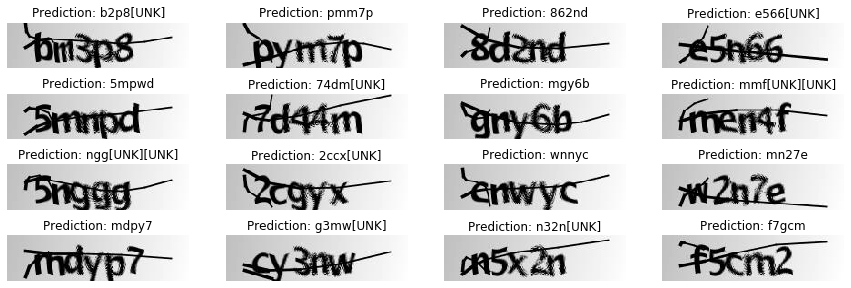

In [36]:
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()